# Project 3: The Relationship between Food Allergies & Autism in Children

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/semester8/STAT5243/Project3'
print("Files in the directory:", os.listdir(folder_path))

Mounted at /content/drive
Files in the directory: ['Homework 3A.gdoc', 'Project3Data.gsheet']


In [2]:
!pip install --upgrade gspread gspread-dataframe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: gspread
    Found existing installation: gspread 6.0.2
    Uninstalling gspread-6.0.2:
      Successfully uninstalled gspread-6.0.2
  Attempting uninstall: gspread-dataframe
    Found existing installation: gspread-dataframe 3.3.1
    Uninstalling gspread-dataframe-3.3.1:
      Successfully uninstalled gspread-dataframe-3.3.1


In [3]:
pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.4 MB/s eta 0:00:00


In [4]:
import pandas as pd
import gspread
from gspread_dataframe import get_as_dataframe

from google.colab import auth
auth.authenticate_user()

from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

sheet_url = 'https://docs.google.com/spreadsheets/d/1b2e8sIImIx0Iuu_Zu3hQi8kB6_9oga-558MPzLcjlzo/edit?gid=0#gid=0'
spreadsheet = gc.open_by_url(sheet_url)

worksheet = spreadsheet.sheet1

data = get_as_dataframe(worksheet)

print(data.head())

   CURFOOD_C  ASDEV_C  CURSKIN_C  CURRESP_C
0          2      2.0          2          1
1          2      2.0          1          1
2          2      2.0          1          1
3          2      2.0          2          2
4          2      2.0          2          2


Data loaded from Google Sheets:
   CURFOOD_C  ASDEV_C  CURSKIN_C  CURRESP_C
0          2      2.0          2          1
1          2      2.0          1          1
2          2      2.0          1          1
3          2      2.0          2          2
4          2      2.0          2          2
Explained Variance Ratio: [0.34973186 0.23768528 0.20695238 0.20563048]


/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


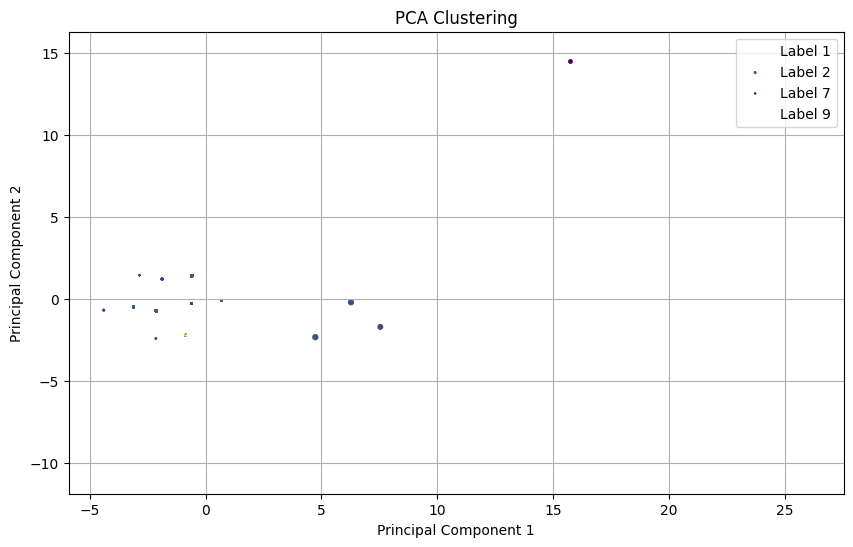

In [5]:
import pandas as pd
import gspread
from gspread_dataframe import get_as_dataframe
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

from google.colab import auth
auth.authenticate_user()

from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

sheet_url = 'https://docs.google.com/spreadsheets/d/1b2e8sIImIx0Iuu_Zu3hQi8kB6_9oga-558MPzLcjlzo/edit?gid=0#gid=0'
spreadsheet = gc.open_by_url(sheet_url)

worksheet = spreadsheet.sheet1

data = get_as_dataframe(worksheet)

print("Data loaded from Google Sheets:")
print(data.head())

data.dropna(inplace=True)

filtered_data = data[data[['CURFOOD_C', 'ASDEV_C', 'CURSKIN_C', 'CURRESP_C']].isin([1, 2, 7, 9, None]).any(axis=1)]

selected_columns = ['CURFOOD_C', 'ASDEV_C', 'CURSKIN_C', 'CURRESP_C']
pca_data = filtered_data[selected_columns]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_data)

pca_result = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(data=pca_result, columns=['CURFOOD_C', 'ASDEV_C', 'CURSKIN_C', 'CURRESP_C'])

pca_df['Food Allergies'] = filtered_data['CURFOOD_C']
pca_df['Respiratory Allergies'] = filtered_data['CURRESP_C']
pca_df['Skin Allergies'] = filtered_data['CURSKIN_C']
pca_df['Autism et al.'] = filtered_data['ASDEV_C']


print("Explained Variance Ratio:", pca.explained_variance_ratio_)
for label in [1, 2, 7, 9]:
    cluster_data = pca_df[(pca_df['Food Allergies'] == label) &
                      (pca_df['Respiratory Allergies'] == label) &
                      (pca_df['Skin Allergies'] == label) &
                      (pca_df['Autism et al.'] == label)]
    plt.scatter(cluster_data['CURFOOD_C'], cluster_data['CURRESP_C'], cluster_data['CURSKIN_C'], cluster_data['ASDEV_C'], label=f"Label {label}")

plt.title('PCA Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

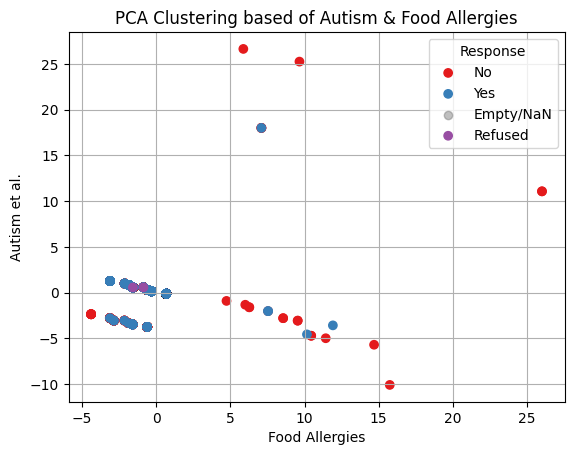

In [6]:
label_columns = ['Food Allergies', 'Respiratory Allergies', 'Skin Allergies', 'Autism et al.']

pca_df['ClusterLabel'] = pca_df[label_columns].apply(lambda row: row.mode()[0] if row.mode().size > 0 else None, axis=1)

import matplotlib.cm as cm
import seaborn as sns

palette = sns.color_palette("Set1", len(pca_df['ClusterLabel'].unique()))

label_mapping = {
    1: "Yes",
    2: "No",
    7: "Refused",
    9: "Don't Know",
    None: "Empty/NaN"
}

legend_order = ["Yes", "No", "Refused", "Empty/NaN"]

for label in pca_df['ClusterLabel'].unique():
    cluster_data = pca_df[pca_df['ClusterLabel'] == label]

    label_text = label_mapping.get(label, 'Unknown')

    if pd.notnull(label):
        color = palette[list(pca_df['ClusterLabel'].unique()).index(label)]
        plt.scatter(cluster_data['CURFOOD_C'], cluster_data['ASDEV_C'],
                    c=[color] * len(cluster_data), label=label_text)
    else:
        plt.scatter(cluster_data['CURFOOD_C'], cluster_data['ASDEV_C'],
                    c='gray', label='Empty/NaN', alpha=0.5)

plt.title('PCA Clustering based of Autism & Food Allergies')
plt.xlabel('Food Allergies')
plt.ylabel('Autism et al.')

handles, labels = plt.gca().get_legend_handles_labels()
order = [legend_order.index(label) for label in legend_order if label in labels]
plt.legend([handles[i] for i in order], [labels[i] for i in order], title='Response', loc='upper right')

plt.grid()
plt.show()

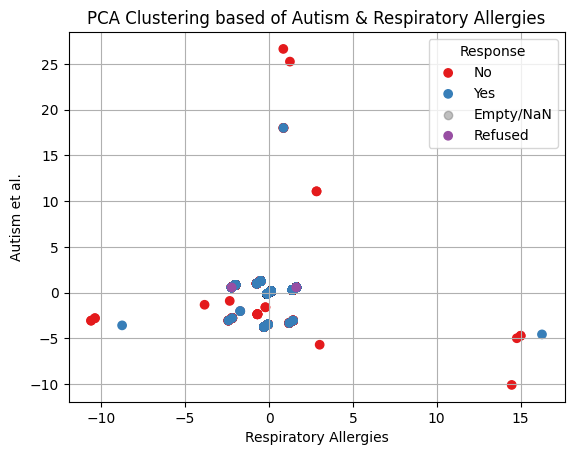

In [7]:
for label in pca_df['ClusterLabel'].unique():
    cluster_data = pca_df[pca_df['ClusterLabel'] == label]

    label_text = label_mapping.get(label, 'Unknown')

    if pd.notnull(label):
        color = palette[list(pca_df['ClusterLabel'].unique()).index(label)]
        plt.scatter(cluster_data['CURRESP_C'], cluster_data['ASDEV_C'],
                    c=[color] * len(cluster_data), label=label_text)
    else:
        plt.scatter(cluster_data['CURRESP_C'], cluster_data['ASDEV_C'],
                    c='gray', label='Empty/NaN', alpha=0.5)

plt.title('PCA Clustering based of Autism & Respiratory Allergies')
plt.xlabel('Respiratory Allergies')
plt.ylabel('Autism et al.')

handles, labels = plt.gca().get_legend_handles_labels()
order = [legend_order.index(label) for label in legend_order if label in labels]
plt.legend([handles[i] for i in order], [labels[i] for i in order], title='Response', loc='upper right')

plt.grid()
plt.show()

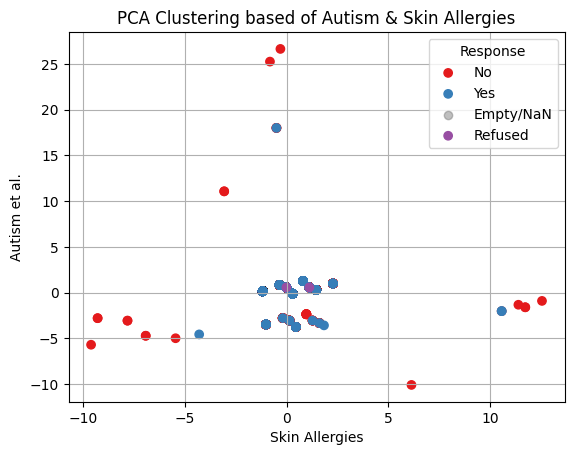

In [8]:
for label in pca_df['ClusterLabel'].unique():
    cluster_data = pca_df[pca_df['ClusterLabel'] == label]

    label_text = label_mapping.get(label, 'Unknown')

    if pd.notnull(label):
        color = palette[list(pca_df['ClusterLabel'].unique()).index(label)]
        plt.scatter(cluster_data['CURSKIN_C'], cluster_data['ASDEV_C'],
                    c=[color] * len(cluster_data), label=label_text)
    else:
        plt.scatter(cluster_data['CURSKIN_C'], cluster_data['ASDEV_C'],
                    c='gray', label='Empty/NaN', alpha=0.5)

plt.title('PCA Clustering based of Autism & Skin Allergies')
plt.xlabel('Skin Allergies')
plt.ylabel('Autism et al.')

handles, labels = plt.gca().get_legend_handles_labels()
order = [legend_order.index(label) for label in legend_order if label in labels]
plt.legend([handles[i] for i in order], [labels[i] for i in order], title='Response', loc='upper right')

plt.grid()
plt.show()

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


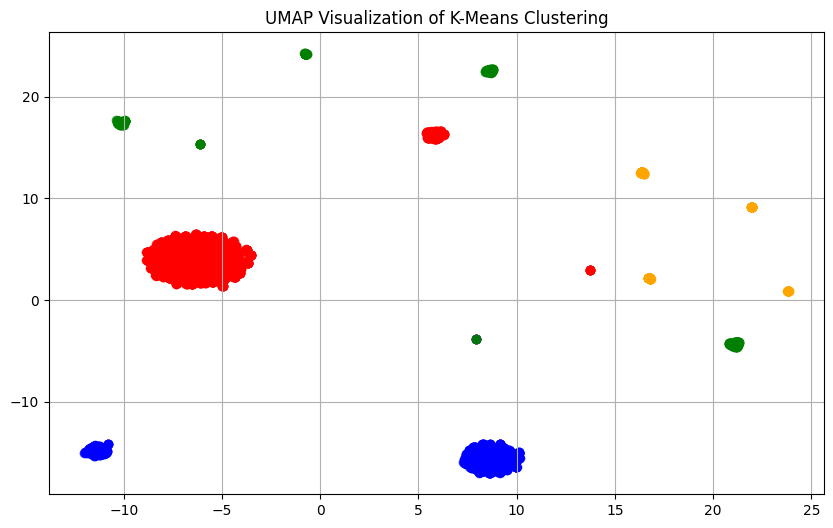

In [9]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

data_columns = ['CURFOOD_C', 'ASDEV_C', 'CURSKIN_C', 'CURRESP_C']

scaler = StandardScaler()
normalized_data = scaler.fit_transform(pca_df[data_columns])

kmeans = KMeans(n_clusters=4, random_state=42)
pca_df['KMeans_Cluster'] = kmeans.fit_predict(normalized_data)

umap = UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_embedding = umap.fit_transform(normalized_data)

plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green', 'orange']

for cluster_label in np.unique(pca_df['KMeans_Cluster']):
    cluster_data = umap_embedding[pca_df['KMeans_Cluster'] == cluster_label]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1],
                color=colors[cluster_label], label=f'Cluster {cluster_label}', alpha=0.7)

plt.title('UMAP Visualization of K-Means Clustering')
plt.grid()
plt.show()

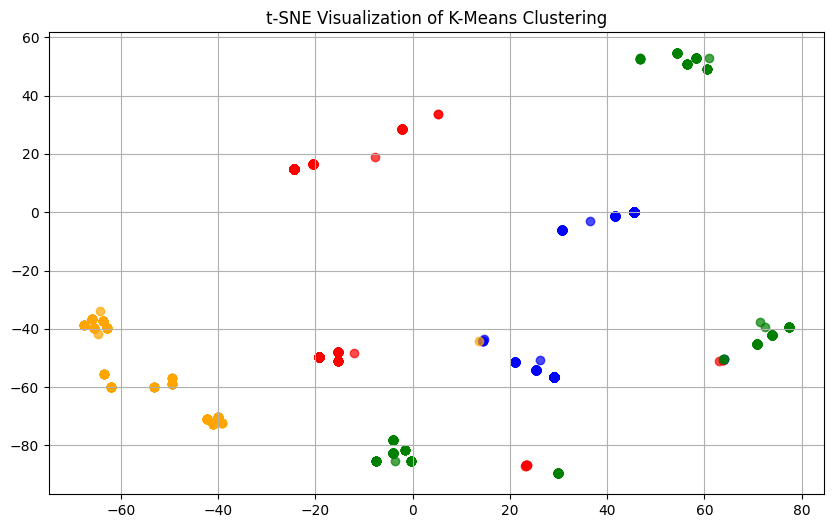

In [10]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

data_columns = ['CURFOOD_C', 'ASDEV_C', 'CURSKIN_C', 'CURRESP_C']

scaler = StandardScaler()
normalized_data = scaler.fit_transform(pca_df[data_columns])

kmeans = KMeans(n_clusters=4, random_state=42)
pca_df['KMeans_Cluster'] = kmeans.fit_predict(normalized_data)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_embedding = tsne.fit_transform(normalized_data)

plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green', 'orange']

for cluster_label in np.unique(pca_df['KMeans_Cluster']):
    cluster_data = tsne_embedding[pca_df['KMeans_Cluster'] == cluster_label]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1],
                color=colors[cluster_label], label=f'Cluster {cluster_label}', alpha=0.7)

plt.title('t-SNE Visualization of K-Means Clustering')
plt.grid()
plt.show()